# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

**Tecnológico de Monterrey**

Prof Luis Eduardo Falcón Morales

**Curva ROC (Clases Balanceadas) y PR (Clases Desbalanceadas)**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix


# **Parte 1: Clases Balanceadas y Curva ROC**

In [2]:
mypath = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"

data = pd.read_csv(mypath, sep=" ", header=None)

data.columns = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','class']

print(data.shape)
data.head(3)

(690, 15)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,class
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0


In [3]:
X = data.iloc[:,:-1]
y = data[['class']]

In [4]:
Xtrain, Xtv, ytrain, ytv = train_test_split(X, y,
                                          train_size=0.7,
                                          stratify=y,   # esto nos garantiza que la partición esté estratificada.
                                          random_state=1)

Xval, Xtest, yval, ytest = train_test_split(Xtv, ytv, stratify=ytv, train_size=0.5, random_state=17)

print(Xtrain.shape, ': dimensión de datos de entrada "X" para entrenamiento')
print(Xval.shape, ': dimensión de datos de entrada "X" para validación')
print(Xtest.shape, ': dimensión de datos de entrada "X" para prueba')
print()
print(ytv.shape, ': dimensión de variable de salida"y" para entrenamiento')
print(yval.shape, ': dimensión de variable de salida "y" para validación')
print(ytest.shape, ': dimensión de variable de salida "y" para prueba')

(482, 14) : dimensión de datos de entrada "X" para entrenamiento
(104, 14) : dimensión de datos de entrada "X" para validación
(104, 14) : dimensión de datos de entrada "X" para prueba

(208, 1) : dimensión de variable de salida"y" para entrenamiento
(104, 1) : dimensión de variable de salida "y" para validación
(104, 1) : dimensión de variable de salida "y" para prueba


In [5]:
print('Clase positiva (se autoriza): %.1f%%' % (100 * (ytv['class'].sum() / ytv.shape[0])))
print('Clase negativa (no se autoriza): %.1f%%' % (100 * (1 - ytv['class'].sum() / ytv.shape[0])))

Clase positiva (se autoriza): 44.7%
Clase negativa (no se autoriza): 55.3%


In [6]:
# Transformaciones a factores numéricos de entrada:
num_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])
num_pipeline_nombres = ['A2','A3','A7','A10','A13','A14']

# Transformaciones a factores categóricos de entrada:
catImp_pipeline = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])
catImp_pipeline_nombres = ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12']

catOHE_pipeline = Pipeline(steps = [('OneHotE', OneHotEncoder(handle_unknown='ignore', drop='first'))])
catOHE_pipeline_nombres = [ 'A4','A5','A6','A12']


# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipeline, num_pipeline_nombres),
                                                        ('catimp', catImp_pipeline, catImp_pipeline_nombres),
                                                        ('catohe', catOHE_pipeline, catOHE_pipeline_nombres)],
                                        remainder='passthrough')

In [34]:
Xxtr = columnasTransformer.fit_transform(Xtrain)
Xxval = columnasTransformer.transform(Xval)
Xxte = columnasTransformer.transform(Xtest)

print(Xtrain.shape)
print(Xxtr.shape)

(482, 14)
(482, 38)


In [8]:
modelo_LR1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=1.).fit(Xxtr, np.ravel(ytrain))

print(modelo_LR1.score(Xxtr,ytrain))
print(modelo_LR1.score(Xxval,yval))

0.8817427385892116
0.8557692307692307


In [35]:
modelo_LR1.coef_

array([[ 0.        , -0.38538098,  0.42717794,  0.        , -2.00881586,
         0.        , -0.05731758,  0.57643273,  0.20622366,  0.05276582,
         3.66746747,  1.09911493, -0.01826059,  0.        ,  0.        ,
         0.19049429,  0.53652306,  0.        ,  0.        ,  0.        ,
        -0.11385159,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.67092614,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.11130942, -0.04875342,  1.36128961,  0.        ,
         0.        , -0.41757685,  2.64605089]])

In [10]:
pred_bin = modelo_LR1.predict(Xxval)   # predicciones en salida binaria: 0s y 1s

cm = confusion_matrix(yval, pred_bin)    # los renglones son los reales y las columnas las predicciones.
print(cm)

[[48 10]
 [ 5 41]]


## **Gráfico para entender la relación entre el umbral de decisión y los FP y FN**

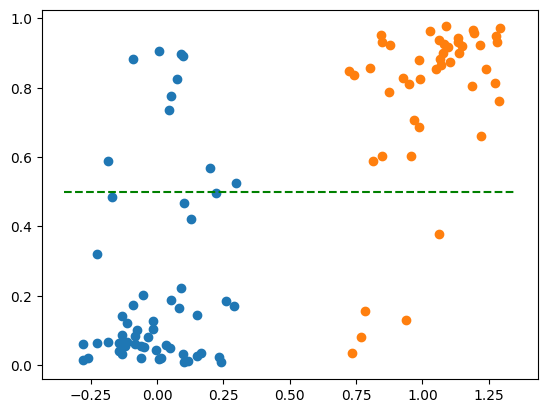

In [11]:
# Obtenemos los índices de las etiquetas reales de los 0s y de los 1s:
my0s = (yval['class']==0)   # Nos quedamos con los índices de clase 0, TRUE y para los 1s con FALSE.
my1s = (yval['class']==1)   # Nos quedamos con los índices de clase 1, TRUE y para los 0s con FALSE-


# Obtenemos las predicciones del modelo en formato probabilístico del conjunto de Validación:
pred = modelo_LR1.predict_proba(Xxval)    # predicciones en formato probabilístico.

# Las probabilidades del modelo para los casos 0s, debieran ser valores entre 0 y 0.5,
# estos valores debieran estar en la columna 1 de la matriz/arreglo de dos columnas "pred":
# NOTA: despliega "pred" para que veas cómo se da la información en este arreglo:
pred0s  = pred[my0s][:,1]

# Análogamente seleccionamos los valores entre 0.5 y 1 de los índices 1s, que también
# debieran estar en la columna 1:
pred1s  = pred[my1s][:,1]

# Generamos valores aleatorios alrededor del 0 (No se autoriza) y del 1 (Se autoriza):
r0 = np.random.uniform(-0.3,0.3, size=pred0s.shape[0])    # Generamos aleatorios uniforme para el eje horizontal
                                                          # de longitud el total de 0-TRUEs en validación, alrededor
                                                          # del 0, por ejemplo entre (-0.3, +0.3)

r1 = np.random.uniform(0.7,1.3, size=pred1s.shape[0])     # El análogo para 1-TRUEs en validación. Aquí alrededor
                                                          # del 1, por ejemplo (+0.7, +1.3)

# Finalmente graficamos los valores de predicción como puntos en un plano 2D:
plt.scatter(x=r0, y=pred0s)   # En teoría todos estos debieran ser menores a 0.5, si el modelo fuera perfecto.
plt.scatter(x=r1, y=pred1s)   # Y todos estos debieran ser mayores a 0.5 para el modelo perfecto.

# Dibujemos la línea horizontal que denota el umbral de decisión, que de manera
# predeterminada es 0.5:
plt.hlines(0.5, -0.35, 1.35, color='g', linestyles='dashed')   # el primer valor es la constante para "y=0.5" y los otros
                                                               # 2 son donde inicia y termina la línea horizontal.
plt.show()

In [12]:
# Observa la relación del gráfico con la matriz de confusión del
# conjunto de Validación y la línea de umbral en 0.5:
print(cm)

[[48 10]
 [ 5 41]]


## **Curva ROC y métrica AUC**

##### **ROC: (Receiver Operating Characteristic): Característica Operativa del Receptor**

##### **AUC: (Area Under Curve): Área Bajo la Curva**

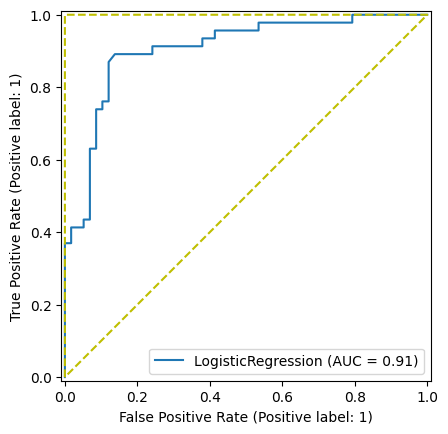

In [13]:
RocCurveDisplay.from_estimator(modelo_LR1, Xxval, yval)  # curva ROC con métrica AUC
plt.plot([0,0,1,0],[0,1,1,0], 'y--')                     # tríangulo de referencia
plt.show()

## **Relación entre la búsqueda del mejor umbral y la curva ROC**


*   ### **Como hemos comentado, el determinar cuál es "el mejor" valor del umbral para la manera en que decide un modelo las clases positivas 1 y las negativas 0, es relativo. Sin embargo, exiten algunas aproximaciones generales, veamos algunas.**

*   ### **Cuando los errores FP y FN se consideran igualmente importantes, el mejor umbral será el que minimice la suma de estos, FP+FN.**

*   ### **Otra manera cuando los errores FP y FN son igual de importantes, es buscar el umbral que conicida con el punto en la curva ROC que inerseca por primera vez al círculo centrado en la esquina superior izquierda.**

*   ### **Si alguno de estos errores se considera más importante, deberá definirse cuál sería el valor mínimo a buscar del más importante y el máximo del otro a tolerar.**



### **Veamos pirmero el caso en que FP y FN son igualmente importantes con el apoyo gráfico del círculo centrado en la esquina superior izquierda.**

In [14]:
# Definiendo la tasa de TP con el nuevo umrbal th:
def fun_thTPrate(th, modelo, x, y):
  p = modelo.predict_proba(x)   # shape (:x2)
  my1s = (y['class']==1)
  pred1s  = p[my1s][:,1]
  return sum(pred1s > th) / sum(my1s)

In [15]:
# Definiendo la tasa de FP con el nuevo umrbal th:
def fun_thFPrate(th, modelo, x, y):
  p = modelo.predict_proba(x)
  my0s = (y['class']==0)
  pred0s  = p[my0s][:,1]
  return sum(pred0s>th) / sum(my0s)

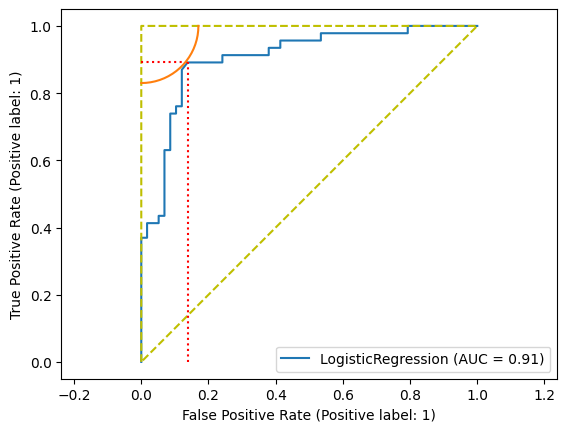

In [41]:
new_th = 0.57     # Búsquda del mejor umbral que minimice el total FP+FN.
rr = 0.17         # Búsqueda del mejor radio


RocCurveDisplay.from_estimator(modelo_LR1, Xxval, yval)   # curva ROC con el modelo de predicción encontrado.
plt.plot([0,0,1,0],[0,1,1,0], 'y--')                      # triángulo verde de referencia.

new_TPrate = fun_thTPrate(new_th, modelo_LR1, Xxval, yval)  # valor de TP con el nuevo umbral
new_FPrate = fun_thFPrate(new_th, modelo_LR1, Xxval, yval)  # valor de FP con el nuevo umbral
plt.hlines(new_TPrate, 0, new_FPrate, colors='r', linestyles='dotted')    # línea horizontal en TP
plt.vlines(new_FPrate, 0, new_TPrate, colors='r', linestyles='dotted')    # línea vertical en FP

# graficando el arco de círculo en el mejor umbral:
an = np.linspace(1.5*np.pi, 2*np.pi, 20)
plt.plot(rr*np.cos(an), rr*np.sin(an)+1)
plt.axis('equal')
plt.show()

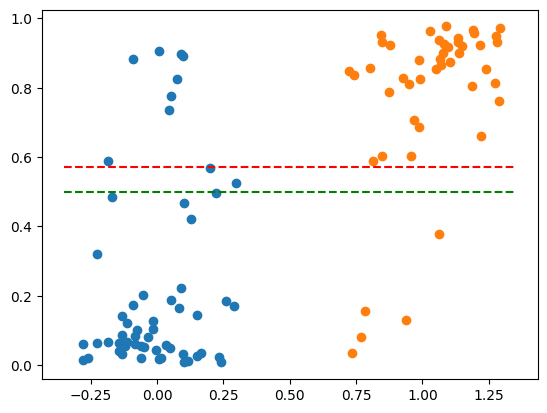

In [17]:
# Graficamos de nuevo la distribución de las predicciones con el nuevo umbral:
plt.scatter(x=r0, y=pred0s)
plt.scatter(x=r1, y=pred1s)
plt.hlines(0.5, -0.35,1.35,color='g',linestyles='dashed')
plt.hlines(new_th, -0.35,1.35,color='r',linestyles='dashed')
plt.show()

### **Veamos ahora el caso de determinar el mejor umbral cuando la  suma FP+FN es mínima**

In [18]:
def fun_thFNrate(th, modelo, x, y):
  p = modelo.predict_proba(x)
  my1s = (y['class']==1)
  pred1s  = p[my1s][:,1]
  return sum(pred1s<th) / sum(my1s)

In [19]:
# Busquemos cuál podría ser el umbral que minimice el total de las razones FP y FN:

tt = [t for t in np.arange(0.1,0.9,.05)]

for i in tt:
  fFP = fun_thFPrate(i, modelo_LR1, Xxval, yval)
  fFN = fun_thFNrate(i, modelo_LR1, Xxval, yval)

  print('(th, FPr+FNr) = (%.2f, %.2f)' % (i, fFP+fFN))

(th, FPr+FNr) = (0.10, 0.53)
(th, FPr+FNr) = (0.15, 0.44)
(th, FPr+FNr) = (0.20, 0.38)
(th, FPr+FNr) = (0.25, 0.35)
(th, FPr+FNr) = (0.30, 0.35)
(th, FPr+FNr) = (0.35, 0.33)
(th, FPr+FNr) = (0.40, 0.35)
(th, FPr+FNr) = (0.45, 0.33)
(th, FPr+FNr) = (0.50, 0.28)
(th, FPr+FNr) = (0.55, 0.26)
(th, FPr+FNr) = (0.60, 0.25)
(th, FPr+FNr) = (0.65, 0.29)
(th, FPr+FNr) = (0.70, 0.34)
(th, FPr+FNr) = (0.75, 0.34)
(th, FPr+FNr) = (0.80, 0.37)
(th, FPr+FNr) = (0.85, 0.50)


## **Curva ROC como comparación del desempeño de varios modelos**

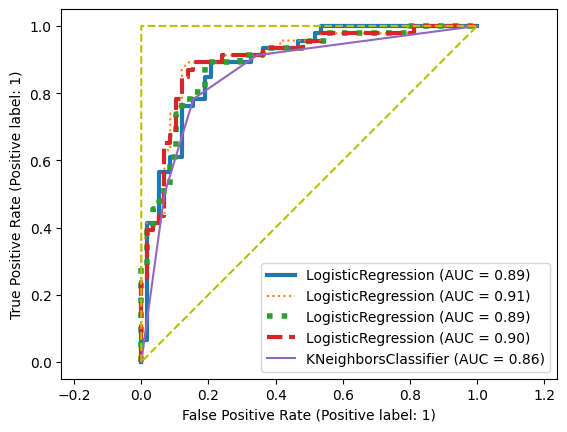

In [20]:
modelo_LR0 = LogisticRegression(penalty=None, solver='lbfgs', max_iter=4000, random_state=1).fit(Xxtr, np.ravel(ytrain))
modelo_LR1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, C=1., random_state=1).fit(Xxtr, np.ravel(ytrain))
modelo_LR2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000, C=10.01, random_state=1).fit(Xxtr, np.ravel(ytrain))
modelo_LR12 = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=4000, C=1., random_state=1).fit(Xxtr, np.ravel(ytrain))
modelo_KNN = KNeighborsClassifier(n_neighbors=3).fit(Xxtr, np.ravel(ytrain))


lr0_curve = RocCurveDisplay.from_estimator(modelo_LR0, Xxval, yval, linewidth=3)
lr1_curve = RocCurveDisplay.from_estimator(modelo_LR1, Xxval, yval, ax=lr0_curve.ax_, linestyle="dotted")
lr2_curve = RocCurveDisplay.from_estimator(modelo_LR2, Xxval, yval, ax=lr1_curve.ax_, linewidth=4, linestyle=":")
lr12_curve = RocCurveDisplay.from_estimator(modelo_LR12, Xxval, yval, ax=lr2_curve.ax_, linewidth=3, linestyle="dashed")
knn_curve = RocCurveDisplay.from_estimator(modelo_KNN, Xxval, yval, ax=lr12_curve.ax_)

plt.plot([0,0,1,0],[0,1,1,0], 'y--')


plt.axis('equal')
plt.show()

**Si recordamos el análisis con los datos de créditos australianos y la comparación con la métrica de exactitud (accuracy), el resultado en cuanto al desempeño comparativo de los modelos fue bastante análogo.**

# **Parte 2: Clases Desbalanceadas y Curva PR**

In [42]:
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

### **Para ilustrar el caso de clases desbalanceadas y su relación con las Curvas ROC y PR, definamos un conjunto artificial de datos con una distribución marcadamente desbalanceada.**

In [22]:
XX, yy = make_classification(n_samples=1000,
                             n_classes=2,
                             weights=[0.95, 0.05],
                             random_state=1)

trainX, vtX, trainy, vty = train_test_split(XX, yy, train_size=0.8, random_state=11, stratify=yy)
valX, testX, valy, testy = train_test_split(vtX, vty, train_size=0.5, random_state=11, stratify=vty)

print('Dataset: Class0=%d, Class1=%d' % (len(yy[yy==0]), len(yy[yy==1])))
print('Train: Class0=%d, Class1=%d' % (len(trainy[trainy==0]), len(trainy[trainy==1])))
print('Val: Class0=%d, Class1=%d' % (len(valy[valy==0]), len(valy[valy==1])))
print('Test: Class0=%d, Class1=%d' % (len(testy[testy==0]), len(testy[testy==1])))

Dataset: Class0=945, Class1=55
Train: Class0=756, Class1=44
Val: Class0=95, Class1=5
Test: Class0=94, Class1=6


In [23]:
# Porcentaje de la clase positiva del conjunto de entrenamiento:
tasa_positiva = len(trainy[trainy==1]) / len(trainy)
print('Clase positiva (1s): %.1f%%' % (100 * tasa_positiva))

Clase positiva (1s): 5.5%


In [43]:
modelo_desbalanceado = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=1.).fit(trainX, trainy)
print(modelo_desbalanceado.score(trainX, trainy))
print(modelo_desbalanceado.score(valX, valy))

0.95875
0.94


In [25]:
ppdd = modelo_desbalanceado.predict(valX)   # predicciones en salida binaria: 0s y 1s
confusion_matrix(valy, ppdd)

array([[94,  1],
       [ 5,  0]])

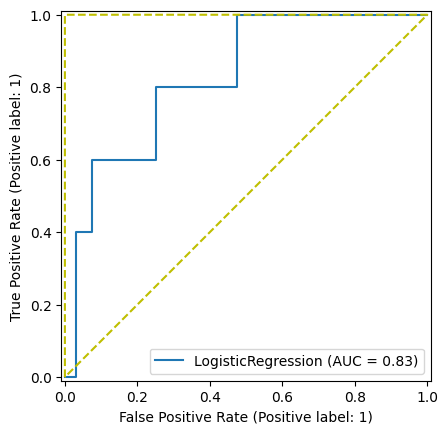

In [26]:
RocCurveDisplay.from_estimator(modelo_desbalanceado, valX, valy)
plt.plot([0,0,1,0],[0,1,1,0], 'y--')
plt.show()

#### **Observamos que la métrica área bajo la curva es muy optimista con un valor de AUC=0.83, aún cuando el modelo está básicamente preocupándose únicamente por la clase mayoritaria.**

#### **Veamos que el gráfico de la curva PR (precision-recall) es más realista en cuanto a medir el desempeño de las predicciones del modelo.**

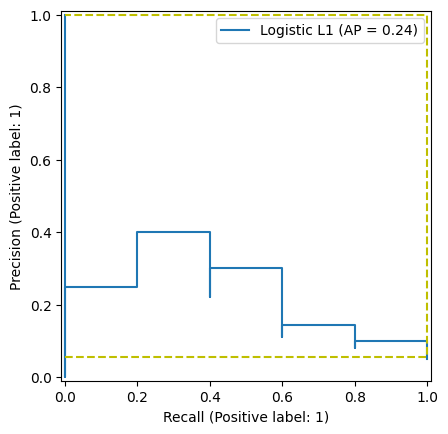

In [27]:
PrecisionRecallDisplay.from_estimator(modelo_desbalanceado, valX, valy,  name="Logistic L1")
plt.plot([0,1,1,0],[tasa_positiva,tasa_positiva,1,1], 'y--')
plt.legend(loc="upper right")
plt.show()

**AP : Average Precision. Esta métrica está dada por el área bajo la curva Precision-Recall.**

**En principio, se desea que los valores de la Precision y el Recall sean altos. Ambos valores aumentan su valor cuando los VP aumentan. O bien, alguno de ellos aumenta cuando alguno de los errores (FP o FN) disminuye.**

Puedes consultar la documentación de la curva PR de scikit-learn:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

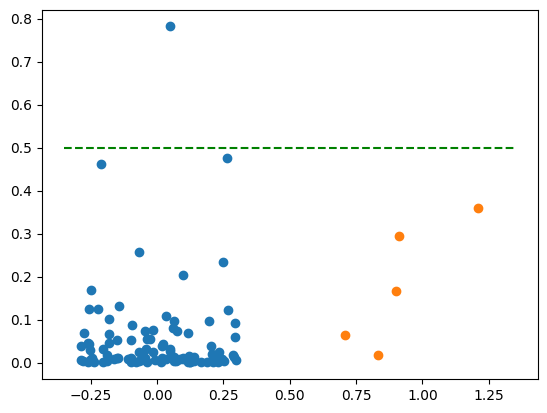

In [28]:
# Procedemos de manera análoga con este nuevo conjunto de datos desbalanceado:

my0s = (valy==0)
my1s = (valy==1)
pred = modelo_desbalanceado.predict_proba(valX)    # predicciones en formato probabilístico.
pred0s  = pred[my0s][:,1]
pred1s  = pred[my1s][:,1]
r0 = np.random.uniform(-0.3,0.3, size=pred0s.shape[0])
r1 = np.random.uniform(0.7,1.3, size=pred1s.shape[0])

plt.scatter(x=r0, y=pred0s)
plt.scatter(x=r1, y=pred1s)
plt.hlines(0.5, -0.35, 1.35, color='g', linestyles='dashed')
plt.show()

In [29]:
confusion_matrix(valy, ppdd)

array([[94,  1],
       [ 5,  0]])

In [30]:
from imblearn.metrics import geometric_mean_score

In [31]:
# Calculando la media-Geométrica, que se recomienda para el caso de clases desbalanceadas,
# y donde FP y FN son igualmente importantes:

geometric_mean_score(valy, ppdd)

0.0

Que la métrica de la media geométrica sea cero en este caso, nos hace ver que con respecto a la clase minoritaria este modelo no está haciendo nada. En contraste con la métrica accuracy=94%.

### **Comparemos el gráfico PR del caso balanceado del ejercicio de créditos autralianos.**

In [32]:
tasa_positiva = len(ytrain[ytrain['class']==1]) / len(ytrain)
print('Clase positiva (1s): %.1f%%' % (100 * tasa_positiva))

Clase positiva (1s): 44.4%


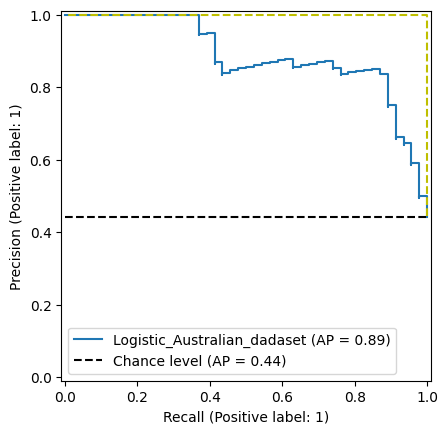

In [33]:
PrecisionRecallDisplay.from_estimator(modelo_LR1, Xxval, yval['class'],  name="Logistic_Australian_dadaset",  plot_chance_level=True)
plt.plot([1,1,0],[tasa_positiva,1,1], 'y--')
plt.show()

**<<< FIN DEL EJERCICIO >>>**